In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from fredapi import Fred
import datetime

# Initialize FRED API
fred = Fred(api_key='8445855393be6d75a6d33bcddffc7958')

In [26]:
# Define the series IDs for the required data
series_ids = {
    '5-Year, 5-Year Forward Inflation Expectation Rate': 'T5YIFR',
    '1 Year Treasury Rate': 'DGS1',
    'fed_balance_sheet_assets': 'WALCL',
    'gdp': 'GDP',
    'Summary of Economic Projections: Longer-Term Federal Funds Rate': 'FEDTARMDLR',
    'US 10yr': 'DGS10',
    'RRP': "WLRRAL",
    'US Treasury General Account' : 'D2WLTGAL'
}

# Fetch the data starting from 11/8/2021
start_date = '2019-11-08'

# Download data and store in a dictionary
data = {name: fred.get_series(series_id, observation_start=start_date) for name, series_id in series_ids.items()}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Resample the monthly GDP to daily frequency using forward fill method
df = df.ffill()

# Calculate the Fed Balance Sheet Assets to GDP ratio
df['Fed BS Assets to GDP'] = df['fed_balance_sheet_assets'] / (df['gdp'] *1000)

# Calculate Net Liquidity Indicator
df['Net Liquidity Indicator'] = df['fed_balance_sheet_assets'] -  df['RRP'] - df['US Treasury General Account']

df = df.drop(['fed_balance_sheet_assets','gdp','RRP','US Treasury General Account'], axis=1)
df=df.dropna()
# Display the DataFrame
print(df.tail(5))

            5-Year, 5-Year Forward Inflation Expectation Rate  \
2025-01-07                                               2.32   
2025-01-08                                               2.33   
2025-01-09                                               2.32   
2025-01-10                                               2.35   
2025-01-13                                               2.35   

            1 Year Treasury Rate  \
2025-01-07                  4.19   
2025-01-08                  4.19   
2025-01-09                  4.16   
2025-01-10                  4.25   
2025-01-13                  4.25   

            Summary of Economic Projections: Longer-Term Federal Funds Rate  \
2025-01-07                                                3.0                 
2025-01-08                                                3.0                 
2025-01-09                                                3.0                 
2025-01-10                                                3.0               

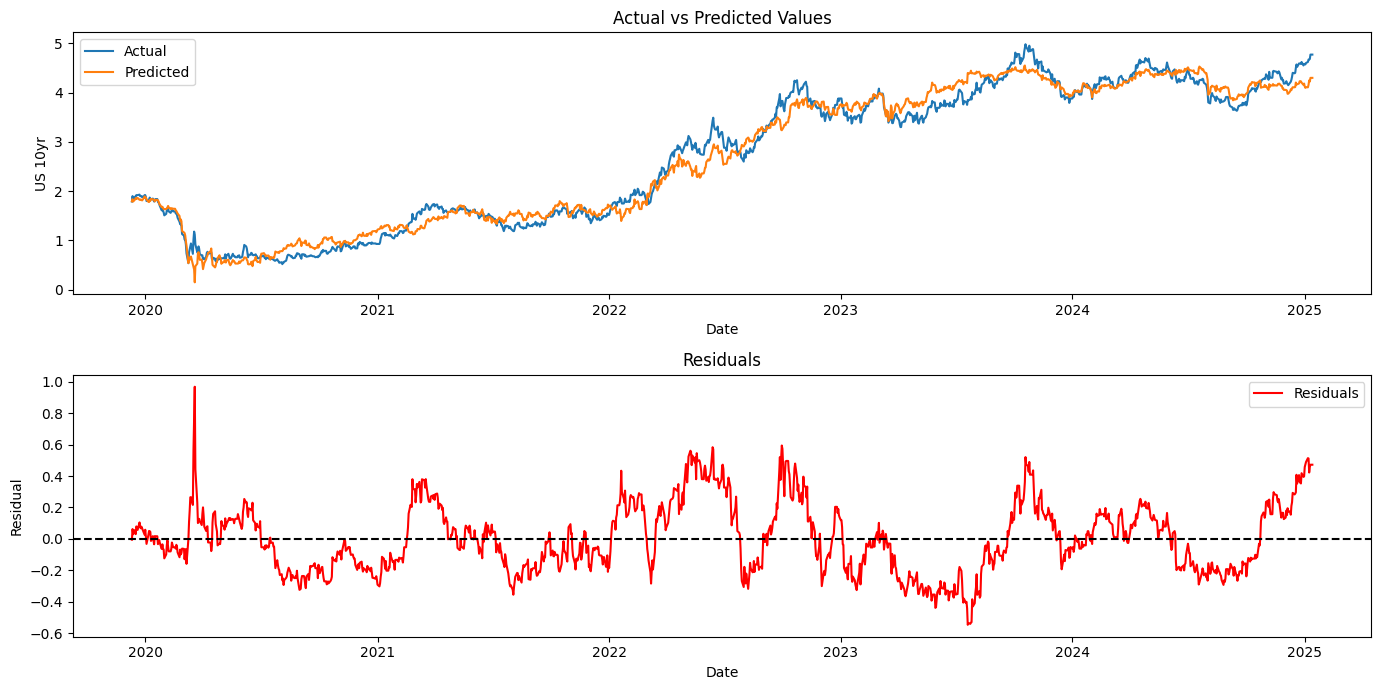

Model Coefficients: [ 1.06260267e+00  4.86216664e-01 -3.69939065e+00  7.12965176e-01
  1.87658309e-07]
Intercept: -2.60368213458465
R^2: 0.9751181625594149
Adjusted R^2: 0.9750245514328514
Current 10-Year Yield: 4.77
Current 10-Year Yield Prediction: 4.2981
Current Implied Value: 0.4719
Percentile rank of the latest value: 97.49%


In [27]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Convert Date to datetime
df['Date'] = pd.to_datetime(df.index)

# Define predictor variables and target variable
X = df[["5-Year, 5-Year Forward Inflation Expectation Rate", "1 Year Treasury Rate", "Fed BS Assets to GDP", "Summary of Economic Projections: Longer-Term Federal Funds Rate","Net Liquidity Indicator"]]
y = df["US 10yr"]

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict values
predictions = model.predict(X)

# Calculate residuals
residuals = y - predictions

# Latest prediction minus latest actual value
latest_diff = y.iloc[-1] - predictions[-1] 

# Output regression information
regression_info = {
    "Intercept": model.intercept_,
    "Coefficients": model.coef_,
    "R^2 Score": model.score(X, y)
}

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))

# Actual vs Predicted
plt.subplot(2, 1, 1)
plt.plot(df['Date'], y, label='Actual', marker='')
plt.plot(df['Date'], predictions, label='Predicted', marker='')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('US 10yr')
plt.legend()

# Residuals
plt.subplot(2, 1, 2)
plt.plot(df['Date'], residuals, label='Residuals', marker='', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()

plt.tight_layout()
plt.show()

# Display regression information and latest difference
#print(regression_info, latest_diff)
print(f"Model Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
r_squared = model.score(X,y)
n = X.shape[0]  # Number of observations
k = X.shape[1]  # Number of predictors
print(f"R^2: {r_squared}")
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
print(f"Adjusted R^2: {adjusted_r_squared}")
print(f"Current 10-Year Yield: {round(y.iloc[-1],4)}")
print(f"Current 10-Year Yield Prediction: {round(predictions[-1],4)}")
print(f"Current Implied Value: {round(latest_diff,4)}")

# Calculate the percentile rank for each value in the series
df['residuals'] = residuals
df['residual percentile_rank'] = df['residuals'].rank(pct=True) * 100

# Display the percentile rank for the latest value in the series
latest_value = df['residuals'].iloc[-1]
latest_percentile_rank = df['residual percentile_rank'].iloc[-1]

print(f"Percentile rank of the latest value: {latest_percentile_rank:.2f}%")


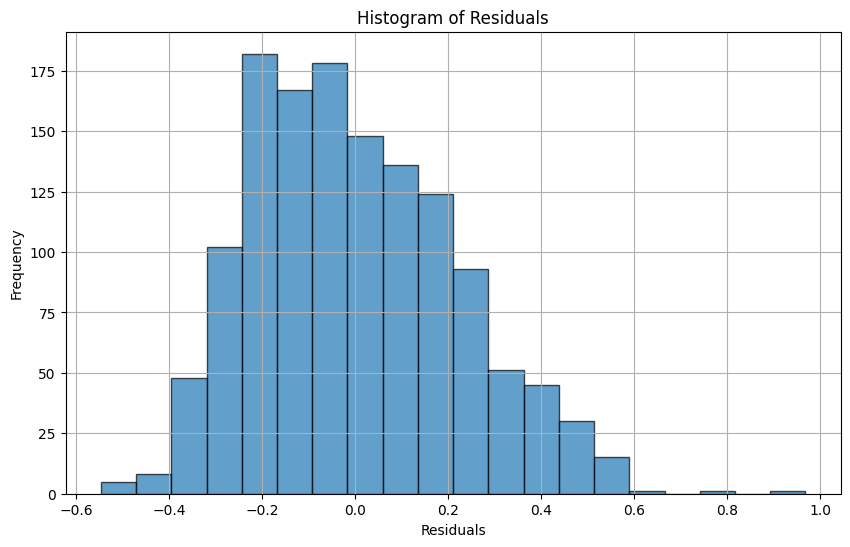

In [28]:
# Create a histogram of the residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()

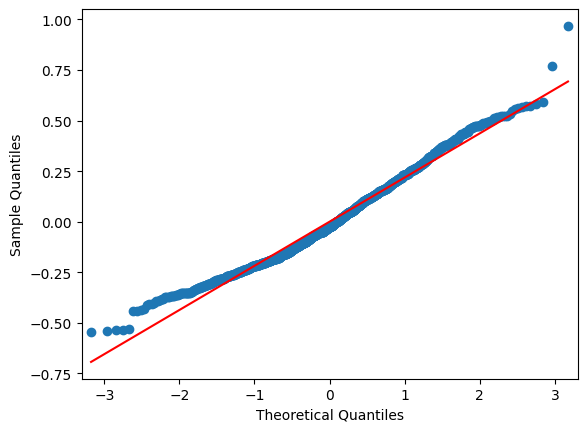

In [29]:
import statsmodels.api as sm
# Create a Q-Q plot for the residuals
sm.qqplot(residuals, line='r')

# Show the plot
plt.show()

In [30]:
df.tail(1)

,"5-Year, 5-Year Forward Inflation Expectation Rate",1 Year Treasury Rate,Summary of Economic Projections: Longer-Term Federal Funds Rate,US 10yr,Fed BS Assets to GDP,Net Liquidity Indicator,Date,residuals,residual percentile_rank
2025-01-13,2.35,4.25,3.0,4.77,0.233313,5661503.0,2025-01-13,0.471938,97.490637


In [31]:
# make predictions with alternative values
X2 = X.tail(1).copy()
X2.loc[X2.index[0],'Summary of Economic Projections: Longer-Term Federal Funds Rate'] = 3.0
print(model.predict(X2))

[4.29806205]


In [32]:
# make predictions with alternative values
X3 = X.tail(1).copy()
X3.loc[X3.index[0],'5-Year, 5-Year Forward Inflation Expectation Rate'] = 2.23
print(model.predict(X3))

[4.17054973]


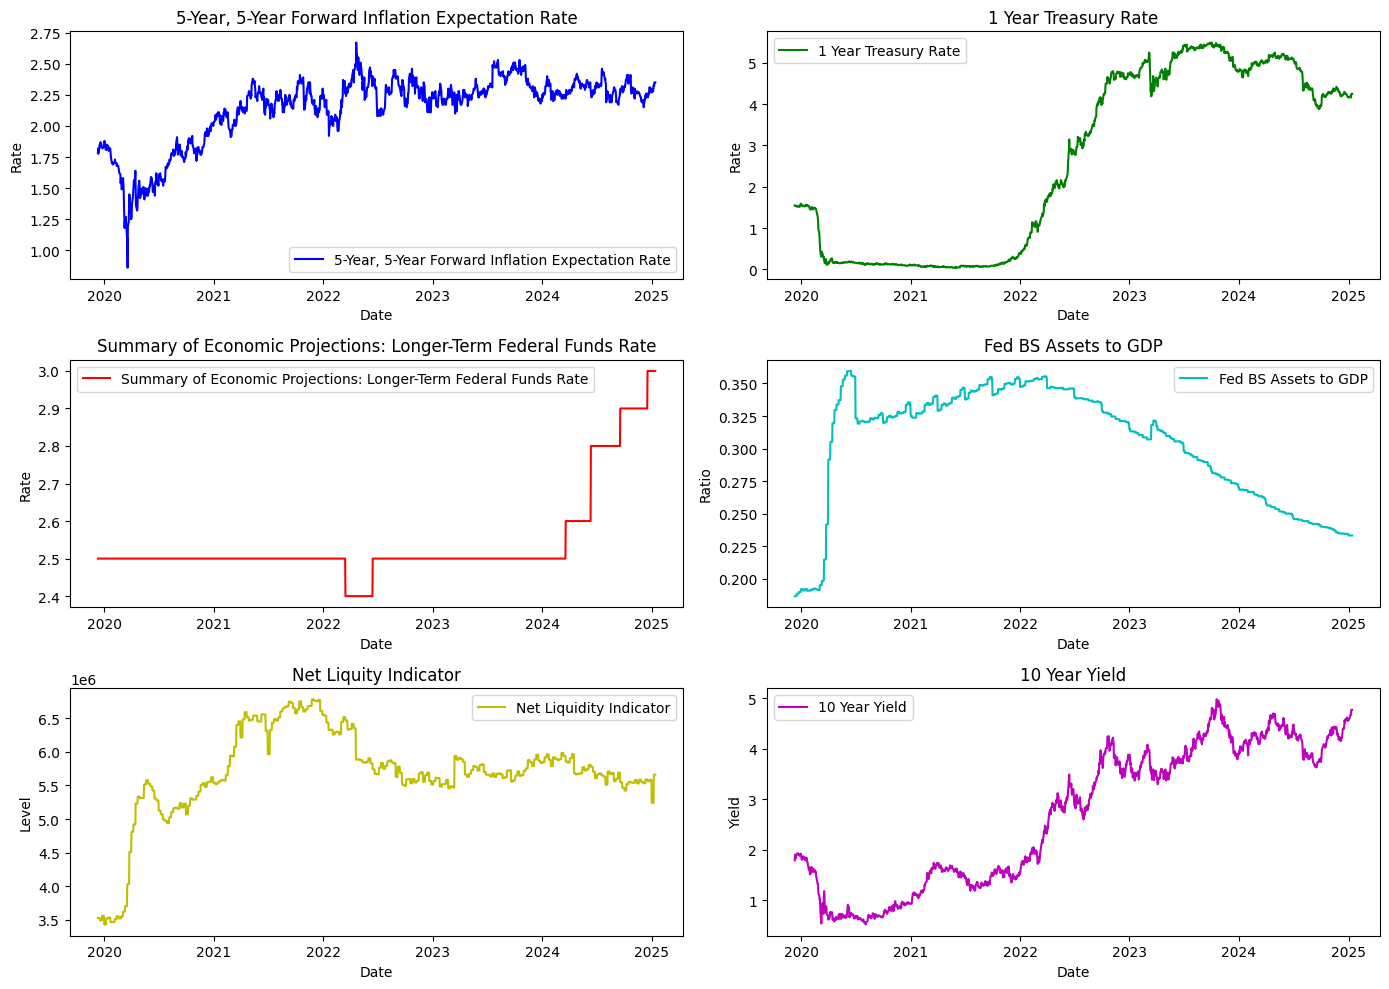

In [33]:
# Plotting the variables
plt.figure(figsize=(14, 10))

# Subplot 1: 5-Year 5-Year Forward Inflation Expectation Rate
plt.subplot(3, 2, 1)
plt.plot(df.index, df['5-Year, 5-Year Forward Inflation Expectation Rate'], label='5-Year, 5-Year Forward Inflation Expectation Rate', color='b')
plt.title('5-Year, 5-Year Forward Inflation Expectation Rate')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

# Subplot 2: 1 Year Treasury Rate
plt.subplot(3, 2, 2)
plt.plot(df.index, df['1 Year Treasury Rate'], label='1 Year Treasury Rate', color='g')
plt.title('1 Year Treasury Rate')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

# Subplot 3: US Total Assets Held by All Federal Reserve Banks
plt.subplot(3, 2, 3)
plt.plot(df.index, df['Summary of Economic Projections: Longer-Term Federal Funds Rate'], label='Summary of Economic Projections: Longer-Term Federal Funds Rate', color='r')
plt.title('Summary of Economic Projections: Longer-Term Federal Funds Rate')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

# Subplot 4: US Monthly GDP
plt.subplot(3, 2, 4)
plt.plot(df.index, df['Fed BS Assets to GDP'], label='Fed BS Assets to GDP', color='c')
plt.title('Fed BS Assets to GDP')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend()

# Subplot 5: US Monthly GDP
plt.subplot(3, 2, 5)
plt.plot(df.index, df['Net Liquidity Indicator'], label='Net Liquidity Indicator', color='y')
plt.title('Net Liquity Indicator')
plt.xlabel('Date')
plt.ylabel('Level')
plt.legend()

# Subplot 6: 10 Year Yield
plt.subplot(3, 2, 6)
plt.plot(df.index, df['US 10yr'], label='10 Year Yield', color='m')
plt.title('10 Year Yield')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

Correlation between Net Liquidity Indicator and inverse of 10 Year Yield: -0.08394528866167279


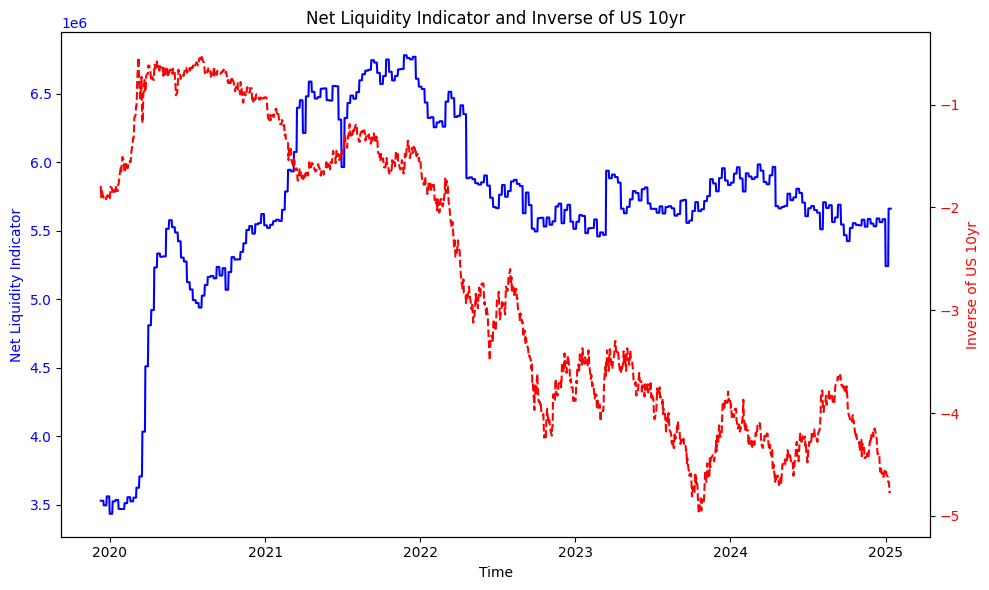

In [34]:

# Calculate the inverse of series_2
inverse_series_2 = -1 * df['US 10yr']

# Calculate the correlation between series_1 and the inverse of series_2
correlation = df['Net Liquidity Indicator'].corr(inverse_series_2)
print(f"Correlation between Net Liquidity Indicator and inverse of 10 Year Yield: {correlation}")

# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot series_1 on the left y-axis
ax1.plot(df['Net Liquidity Indicator'], label='Net Liquidity Indicator', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Net Liquidity Indicator', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for inverse_series_2
ax2 = ax1.twinx()
ax2.plot(inverse_series_2, label='Inverse of US 10yr', color='red', linestyle='--')
ax2.set_ylabel('Inverse of US 10yr', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and layout
plt.title('Net Liquidity Indicator and Inverse of US 10yr')
fig.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

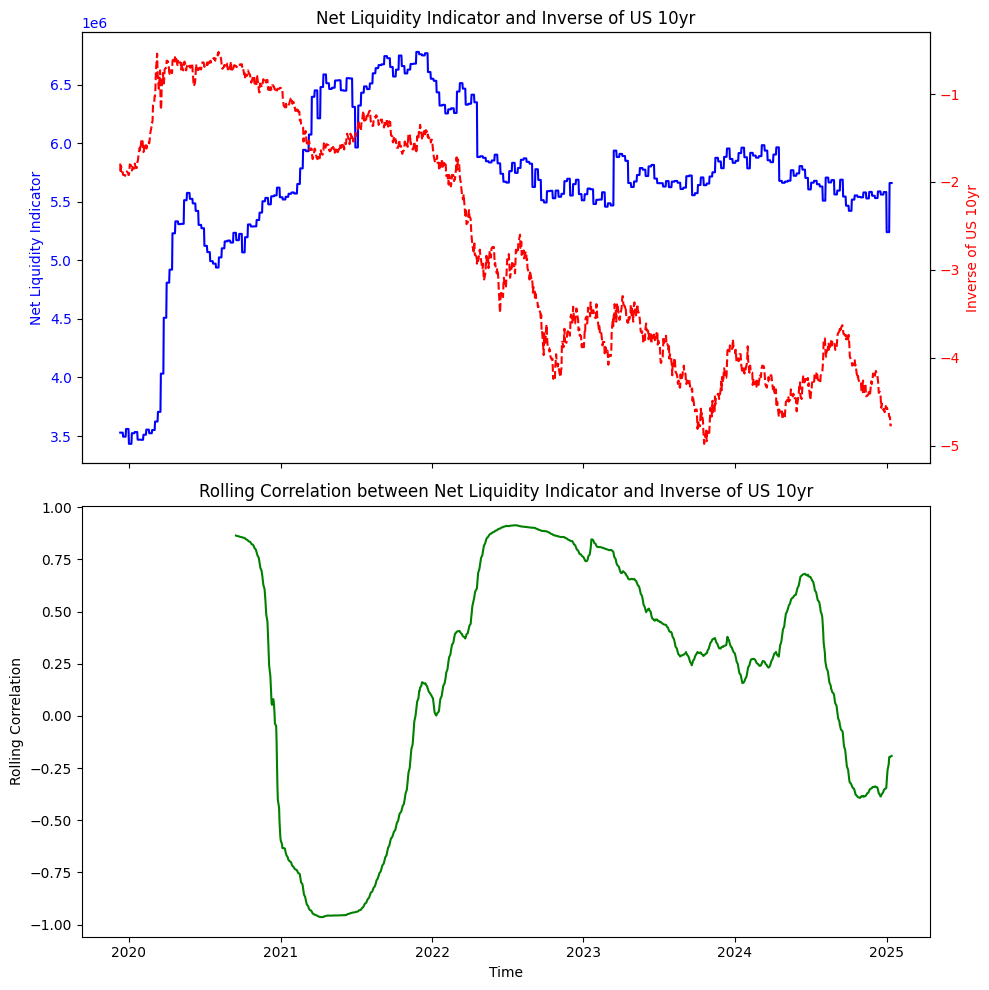

In [35]:
# Calculate the rolling correlation with a window size of 20 (adjust as needed)
window_size = 200
df['rolling_corr'] = df['Net Liquidity Indicator'].rolling(window=window_size).corr(inverse_series_2)

# Plot the data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot series_1 and inverse_series_2 on their own scales in the first panel
ax1.plot(df['Net Liquidity Indicator'], label='Net Liquidity Indicator', color='blue')
ax1.set_ylabel('Net Liquidity Indicator', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for inverse_series_2
ax1_right = ax1.twinx()
ax1_right.plot(inverse_series_2, label='US 10yr', color='red', linestyle='--')
ax1_right.set_ylabel('Inverse of US 10yr', color='red')
ax1_right.tick_params(axis='y', labelcolor='red')
ax1.set_title('Net Liquidity Indicator and Inverse of US 10yr')

# Plot the rolling correlation in the second panel
ax2.plot(df['rolling_corr'], label='Rolling Correlation', color='green')
ax2.set_ylabel('Rolling Correlation')
ax2.set_xlabel('Time')
ax2.set_title('Rolling Correlation between Net Liquidity Indicator and Inverse of US 10yr')

# Layout adjustments
fig.tight_layout()
plt.show()

In [36]:
import openpyxl

# Load the third tab of the Excel file
residuals.to_excel('ten year residuals data.xlsx')
df.to_excel('10 Year Model Data for Analysis.xlsx')